# 1. Setup and Dependencies

Before we begin, we install the `datasets` library from Hugging Face to easily access the required dataset. We also import **PyTorch**, which we will be using as our deep learning framework.

**Key Imports:**
* `torch.nn`: Contains the building blocks for neural networks (LSTM layers, Linear layers, etc.).
* `datasets`: Used to download the text data.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 2. Data Loading & Preprocessing

Since we are building a Character-Level LSTM, our "vocabulary" consists of individual characters (letters, punctuation, newlines) rather than full words.

**What this cell does:**
1.  **Loads WikiText-2:** This is the dataset by Salesforce we have chosen for our model, which is often used for language modeling benchmarks.
2.  **Builds Vocabulary:** Scans the text to find all unique characters (approx. 200-300 unique chars).
3.  **Numerical Encoding:** Creates a mapping (`char_to_idx`) to convert characters into integers, which is the format the neural network requires.

### Understanding with an Example

To visualize exactly what the code above does, let's pretend our entire `text` variable is just the word **"mississippi"**.

#### 1. Extract & Sort Unique Characters
The code `sorted(list(set(text)))` finds the unique letters and sorts them alphabetically.

* **Raw Text:** `"mississippi"`
* **Unique Set:** `{'m', 'i', 's', 'p'}`
* **Sorted List (`chars`):** `['i', 'm', 'p', 's']`

#### 2. Create Mappings (`char_to_idx`)
We assign a unique integer to each character based on its sorted position.

| Index | Character |
| :--- | :--- |
| 0 | **i** |
| 1 | **m** |
| 2 | **p** |
| 3 | **s** |

#### 3. Encoding the Text
The function `encode_text` replaces every letter in the original string with its corresponding integer.

* **Original:** `m` `i` `s` `s` `i` `s` `s` `i` `p` `p` `i`
* **Encoded:** `1` `0` `3` `3` `0` `3` `3` `0` `2` `2` `0`

**Result:** The model receives the tensor `[1, 0, 3, 3, 0, 3, 3, 0, 2, 2, 0]` instead of the raw text.


In [5]:
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1')

# Extract and join the train and validation splits into a single
# long string each separated by newline characters '\n'
text = "\n".join(dataset['train']['text'])
val_text = "\n".join(dataset['validation']['text'])

# Create Vocabulary
chars = sorted(list(set(text)))
chars.append('<UNK>')
vocab_size = len(chars)
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

print(f"Total characters in training set: {len(text)}")
print(f"Unique characters (Vocabulary Size): {vocab_size}")
print(f"Vocabulary: {''.join(chars)}")

# Function to encode text to integers
def encode_text(txt):
    unk_idx = char_to_idx['<UNK>']
    return torch.tensor([char_to_idx.get(c, unk_idx) for c in txt], dtype=torch.long)

# Encode datasets
train_data = encode_text(text)
val_data = encode_text(val_text)

print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Total characters in training set: 10929707
Unique characters (Vocabulary Size): 1014
Vocabulary: 
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz|}~¡¢£¥§°±²³´µ·º½¿ÁÄÅÆÇÉÍÎÑÓÖ×ØÚÜÞßàáâãäåæçèéêëìíîïðñòóôöøùúûüýþĀāăąćČčĐđĒēĔĕėęğħīİıĽŁłńŌōœřŚśŞşŠšţũūůųźŻżŽžơưǎǔȘșțȯɐɑɒɔəɛɜɡɢɪɫɳɽɾʁʃʊʋʒʔʕʲʻʼʾʿˈˌː̥̯͍́̃̍ΑΔΚΝΠΤΦΧΩάέήίαβγδεηθικλμνξοπρςστυχψωόύώАБВГКПРСУХЯавгдежзийклмнопрстухцшъыьюяєֵֶָֹּאבגהוזחילםמןנסףפצרשתءأإابةتثجحخدذرسشصعفقكلمنهويܐܕܗܝܠܢܬܲܵंअईकगणतदनपबमयरलवसहािुूेै्আলহা্ਅਲਹਾੁੱഅളഹാ്กคงชซญฐณดตนบปพภมยรลวศษสหอฮะัาิีึเแไ็่้๊์ႠႢႣႨႬႵႿაბგდევზთიკლმნოპჟრსტუფქღყშჩცძწჭხჯჰჱჲჳჴჵჶჷჸჹჺ჻ᵻḍḏḤḥḷṃṅṇṛṣṭṯạảấầậắễệịọỏỗộớứửữỳỹἀἰὀὁὑ​‐‑–—―‘’“”„†‡•…′″⁄₣₤€₹⅓⅔→−≡≤①☉☫♀♭♯⚳〈〉〜あいうおかがきぎくぐけこごさしすずぜただちっつとなにのはばひふほまみめもゃゆょらりるれわをんァアィイゥェエォオカガキクグゲコサシジスズセタダチッツテデトドナニネノハバパフブプヘベマミムモャュョラリルレロンヴ・ー一七下世丙中主乃之乙九二云人今付作侗依信傳儚充光全兵其具円再出判前剛劇劉動化北华厂去古可台史同名君吳周命和咲善四國園圣在坂堤場塘夕大天夫女妙姚子孟守安宋完宗宝宫寝寺小少尾山岳川州巳市師平广庆府座廬建式張彌彩彼後御德思愛憑憶應懷战戦扈技拉拳挑揺攻放政散斯方日旦旭昌明星春晋景曦月望未本李村杜束来林桜梶棘椎楊楚榮橘機正殻殿母水汉沂沙河泗波泣洪淹清湯漢澄澤火灯灵灼焼熱物狐狸玄王玩珂珙球理琦琪瓊生田畢番瘡白皮真砲礮祈神祠

---
# 3. **Your Task**: Define the LSTM Model

In this step, you will define the architecture of the Recurrent Neural Network. We will use an **LSTM (Long Short-Term Memory)** network, since it is excellent at learning sequences.

Your goal is to complete the `CharLSTM` class below. The model consists of three main components that transform the data step-by-step.

#### 1. The Components (`__init__`)
You need to define three layers:
* **Embedding Layer:** This converts our simple integer inputs (like `1` for 'm') into dense, meaningful vectors. It turns a single number into a list of floating-point numbers that represent that character's "meaning."
* **LSTM Layer:** The core engine. It takes the embeddings and processes them sequentially, updating its internal "memory" (hidden state) at every step.
* **Fully Connected (Linear) Layer:** This takes the output of the LSTM and maps it back to the size of our vocabulary. It produces a score for every possible next character, telling us which character is most likely to come next.

#### 2. The Forward Pass (`forward`)
This function defines how data flows through the network:
1.  **Input:** Takes a batch of character indices (e.g., `[1, 0, 3...]` for "miss...").
2.  **Embed:** Pass indices through the Embedding layer.
3.  **Process:** Pass the embeddings into the LSTM layer along with the previous `hidden` state.
4.  **Reshape:** Flatten the output so the Linear layer can process it (stacking the batch and sequence dimensions).
5.  **Output:** Pass the flattened data through the Fully Connected layer to get prediction scores (logits).

#### 3. Hidden State Initialization (`init_hidden`)
LSTMs need a "starting state" (short-term and long-term memory) before they see any data. This function should create tensors of zeros for both the hidden state and cell state.

In [6]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, n_layers, dropout=0.5):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Define the Embedding layer
        # It should take input of size 'vocab_size' and output vectors of size 'embed_size'
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # Define the LSTM layer
        # Input size should be 'embed_size', output 'hidden_size'.
        # Don't forget 'batch_first=True' and the dropout argument.
        self.lstm = nn.LSTM(embed_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # Define the Fully Connected (Linear) layer
        # It maps from 'hidden_size' -> 'vocab_size'
        self.fc = nn.Linear(hidden_size, vocab_size)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        """
        x: (batch_size, seq_len) -> Input batch of character indices
        hidden: (n_layers, batch_size, hidden_size) -> Previous memory state
        """

        # 1. Pass input x through embedding and then dropout
        embedded = self.dropout(self.embedding(x))

        # 2. Pass embeddings into the LSTM
        # Hint: The LSTM returns two things: output and the new hidden state
        lstm_out, hidden = self.lstm(embedded, hidden)

        # 3. Reshape lstm_out to be compatible with the Linear layer (DONE FOR YOU)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)

        # 4. Pass flattened output through the Linear (fc) layer to get logits
        logits = self.fc(lstm_out)

        return logits, hidden

    def init_hidden(self, batch_size):
        """ Initializes hidden state and cell state to zeros """
        # Get the weight tensor to determine the device automatically (DONE FOR YOU)
        weight = next(self.parameters()).data

        # TODO: Initialize 'hidden' state and 'cell' state with zeros.
        # Shape for both: (n_layers, batch_size, hidden_size)
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_size).zero_(), weight.new(self.n_layers, batch_size, self.hidden_size).zero_())

        return hidden

# 4. Helper Functions: Batching & Generation

We need two utility functions to make training and testing easier:

1.  **`get_batch`**: Instead of training on the whole text at once (which is too large), we grab random chunks (sequences).
    * **Input (`x`):** A sequence of characters (e.g., "Hell").
    * **Target (`y`):** The same sequence shifted by one (e.g., "ello"). This teaches the model to predict the next character.

2.  **`generate_text`**: This function allows us to "talk" to the model.
    * It feeds a starting string (prompt) into the model.
    * It takes the predicted character, feeds it back in as the next input, and repeats the process.
    * **Temperature Sampling:** It uses a "temperature" parameter to control randomness (explained in step 6).

In [7]:
def get_batch(data, seq_len, batch_size):

    # Random starting points
    ix = torch.randint(0, len(data) - seq_len - 1, (batch_size,))

    # Stack inputs (x) and targets (y)
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix]) # Target is x shifted by 1

    return x.to(device), y.to(device)

def generate_text(model, start_str="The", length=200, temperature=1.0):
    model.eval() # Set to evaluation mode
    input_idxs = encode_text(start_str).unsqueeze(0).to(device) # (1, seq_len)
    hidden = model.init_hidden(1)

    generated_text = start_str

    with torch.no_grad():
        # Warm up hidden state with the start string
        for i in range(len(start_str) - 1):
            _, hidden = model(input_idxs[:, i:i+1], hidden)

        # Generate new characters
        last_char_idx = input_idxs[:, -1:]
        for _ in range(length):
            logits, hidden = model(last_char_idx, hidden)

            # Apply temperature
            probs = torch.softmax(logits / temperature, dim=-1)

            # Sample from the distribution
            last_char_idx = torch.multinomial(probs, 1)

            # Append to result
            generated_char = idx_to_char[last_char_idx.item()]
            generated_text += generated_char

    return generated_text

# 5. Training the Model

This is the main loop where the model learns. We use the **Adam optimizer** and **CrossEntropyLoss**.

**Key Concepts in this Loop:**
* **Hidden State Initialization:** At the start of each random batch, we initialize the hidden state to zeros.
* **Gradient Clipping (`clip_grad_norm_`):** RNNs and LSTMs can suffer from "exploding gradients" (where error signals become too large). We clip them to a maximum value of 5 to keep training stable.
* **Validation:** Every 200 steps, we pause training to check the loss on unseen data (validation set) and generate a sample string. This helps us see if the model is actually learning English or just memorizing noise.
---
# **Your Task**: Hyperparameter Tuning
Modify the parameters below to maximize performance.

Experiment with different values to minimize validation loss by trial and error.

In [8]:
##############################################################

# Define the hyperparameters
vocab_size = len(chars)
embed_size = 128
hidden_size = 256
n_layers = 2
seq_len = 100
batch_size = 128
lr = 0.003
epochs = 2000
print_every = 200

##############################################################

# Initialize Model
model = CharLSTM(vocab_size, embed_size, hidden_size, n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Tracking metrics
train_losses = []
val_losses = []

print("Starting Training...")
model.train()
for step in range(1, epochs + 1):
    # Get batch
    inputs, targets = get_batch(train_data, seq_len, batch_size)

    # Init hidden state
    hidden = model.init_hidden(batch_size)

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass
    output, hidden = model(inputs, hidden)

    # Calculate loss
    loss = criterion(output, targets.view(-1))

    # Backward pass
    loss.backward()

    # Clip gradients to prevent exploding gradients (common in RNNs)
    nn.utils.clip_grad_norm_(model.parameters(), 5)

    optimizer.step()

    train_losses.append(loss.item())

    if step % print_every == 0:
        # Validation Check
        val_inputs, val_targets = get_batch(val_data, seq_len, batch_size)
        val_hidden = model.init_hidden(batch_size)
        val_output, _ = model(val_inputs, val_hidden)
        val_loss = criterion(val_output, val_targets.view(-1))
        val_losses.append(val_loss.item())

        print(f"Step {step}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")
        print(f"Sample Gen: {generate_text(model, start_str='The ', length=50, temperature=0.8)}")
        print("-" * 50)
        model.train() # Reset to train mode

Starting Training...
Step 200/2000 | Train Loss: 2.4448 | Val Loss: 2.4490
Sample Gen: The Hamastilaens at , Eanttelenten 's the srated ond p
--------------------------------------------------
Step 400/2000 | Train Loss: 2.2650 | Val Loss: 2.2252
Sample Gen: The pun or , the dealellel wupte the an , criilalfer ,
--------------------------------------------------
Step 600/2000 | Train Loss: 2.1419 | Val Loss: 2.1642
Sample Gen: The from fort goused the Upionies the prayed strubecte
--------------------------------------------------
Step 800/2000 | Train Loss: 2.1013 | Val Loss: 2.0579
Sample Gen: The the at hels in the nest in lemered of folly on guc
--------------------------------------------------
Step 1000/2000 | Train Loss: 2.0261 | Val Loss: 2.0335
Sample Gen: The reporing to of compisuring in the Baided and fort 
--------------------------------------------------
Step 1200/2000 | Train Loss: 1.9875 | Val Loss: 1.9611
Sample Gen: The condical Ry magairings of begover , commames . 

# 6. Visualizing Data

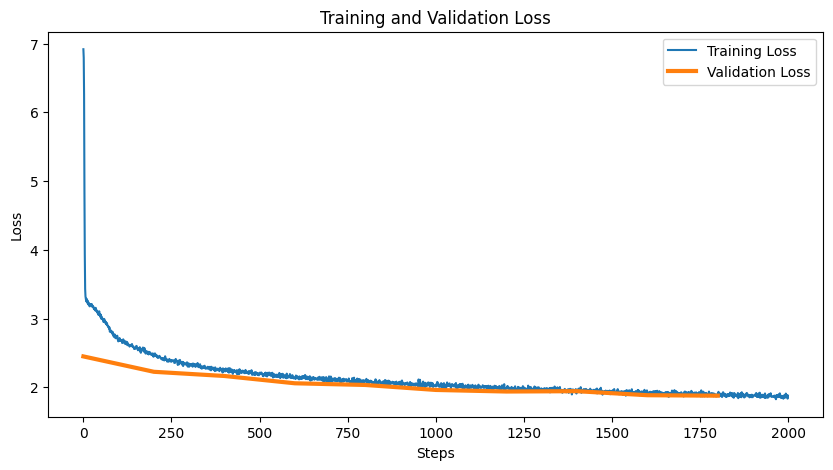

In [9]:
# Plotting Loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
# Scale validation x-axis to match training steps
val_steps = [i * print_every for i in range(len(val_losses))]
plt.plot(val_steps, val_losses, label='Validation Loss', linewidth=3)
plt.title("Training and Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 7. Temperature Sampling & Probing Experiment

Now comes the fun part! We will use our trained LSTM to generate completely new text character-by-character.

### Understanding "Temperature"
When the model predicts the next character, it assigns a probability to every letter in the alphabet. We don't always want to pick the "most likely" letter (that would be boring and repetitive). Instead, we **sample** from the list of possibilities.

We use a hyperparameter called **Temperature (`T`)** to control how "risky" the model is allowed to be:

* **Low Temperature ($T < 0.5$):** The model plays it safe. It makes the high probabilities even higher.
    * *Result:* The text is grammatically correct but very conservative and repetitive.
* **High Temperature ($T \geq 1.0$):** The model flattens the probabilities, giving "rare" characters a fighting chance.
    * *Result:* The text is more creative and diverse, but might contain spelling errors or nonsense words.

Observation: The "Unclosed Bracket" Problem
In the code below, when we set the seed with an open parenthesis, for example, `(The `. Watch closely to see if the model successfully closes the parenthesis `)` later in the paragraph.

Does it successfully close the bracket, or does it fail to? Why do you think this happens?

---
# **Your Task**
1.  Run the cell to see how the model behaves at different temperatures.
2.  Experiment: Change the `seed_text` variable to something else (e.g., your name, "The meaning of life is", etc.).
3.  Compare the output of Temperature 0.2 vs. 1.0. Which one feels more "human"?

In [11]:
def predict(model, char, h=None, top_k=None, temperature=1.0):
    """
    Given a character, predict the next character.
    Returns the predicted character and the hidden state.
    """
    # Prepare input
    x = np.array([[char_to_idx[char]]])
    x = torch.from_numpy(x)

    # Move to device
    # Check if the model's parameters are on GPU to determine device
    device = next(model.parameters()).device
    x = x.to(device)

    # Detach hidden state from history
    h = tuple([each.data for each in h])

    # Get output from model
    model.eval()
    out, h = model(x, h)

    # Apply temperature scaling to logits
    # out shape is (batch, seq, vocab), we want the last step: out[0, -1, :]
    out = out[-1]
    prob = F.softmax(out / temperature, dim=0).data

    # Sample from the distribution
    # This introduces the "randomness" based on the probabilities
    char_ind = torch.multinomial(prob, 1).item()

    return idx_to_char[char_ind], h

def sample(net, size, prime='The', temperature=1.0):
    """
    Generates a sequence of text.
    """
    device = next(net.parameters()).device
    net.to(device)
    net.eval() # Evaluation mode

    # First, run the prime characters through to build up the hidden state
    chars = [ch for ch in prime]
    h = net.init_hidden(1) # Batch size 1

    for ch in prime:
        char, h = predict(net, ch, h, temperature=temperature)

    chars.append(char)

    # Now pass in the previous character and generate new ones
    for ii in range(size):
        char, h = predict(net, chars[-1], h, temperature=temperature)
        chars.append(char)

    return ''.join(chars)

# --- PROBING EXPERIMENT ---

seed_text = "(Once upon a time in a faraway city "  # Change this to whatever you want the model to start with
gen_length = 400    # How many characters to generate

print(f"--- PROBING MODEL BEHAVIOR (Seed: '{seed_text}') ---\n")

# 1. Low Temperature
print("Temperature 0.2 (Safe/Repetitive):")
print(sample(model, gen_length, prime=seed_text, temperature=0.2))
print("\n" + "-"*50 + "\n")

# 2. Medium Temperature
print("Temperature 0.5 (Balanced):")
print(sample(model, gen_length, prime=seed_text, temperature=0.5))
print("\n" + "-"*50 + "\n")

# 3. High Temperature
print("Temperature 1.0 (Creative/Risky):")
print(sample(model, gen_length, prime=seed_text, temperature=1.0))

--- PROBING MODEL BEHAVIOR (Seed: '(Once upon a time in a faraway city ') ---

Temperature 0.2 (Safe/Repetitive):
(Once upon a time in a faraway city , and the second and second of the contersion of the served the song of the state of the first the served the formed the second of the seart of the second to the served the strand of the state the second of the second of the state of the state of the second of the season of the served the second and the contract of the seart of the song and the south the seart of the second to the state of the stat

--------------------------------------------------

Temperature 0.5 (Balanced):
(Once upon a time in a faraway city . In the end the score the and a stated the shot of the deluging a completed to the part of the series , and service , and a resures . 

 The elest to ground beleased to the proves , on 2016 . The consition of a grough and " and the Refent , and the first book of prodical and puble of the part of the August of the Corlist some of